# <font size="5">Study of Impact of Covid-19 on air pollution of Delhi region.</font>
    Due to Covid-19 lockdowns, most of industries, factories and transportation was completely shutdown. Here in this study effect of Covid-19 in Air pollution will be studied. For this work, area of study selected is delhi region because delhi is capital of india and has most number of air quality meter around the state. so study can be done more precisely due to availability of AQI parameraters data over past few year at various points across the city.


In [1]:
#Import Library which is used during the project

import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Polygon, Point

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation
%matplotlib inline

import seaborn as sns

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

import glob
import os

from scipy.spatial import Voronoi, voronoi_plot_2d

from PIL import Image
import IPython

from IPython.display import HTML

import rasterio
import gdal
import rasterio.mask as msk
import rasterio.plot as rasplot

import osgeo

from moviepy.editor import *

import warnings
warnings.filterwarnings('ignore')



/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Parameter which effects the overall air quality is measured at various locations across the world and this data is available on the https://aciqn.org. We required historical air quality data to see the effect of Covid-19 on the environment and also required locations (latitude and Longitude) of points over which these Air quality meters are placed so AQI can be interpolate and visualise over map of area of study.
To fetch the list of all measurement points available over the study region, i fetch list of all data points currently working by using ACIQN API. What i did was fetched the live AQI data over the delhi and nearby region through there API by bouding the area within specified Latitude and Longitude limits over the region. Than. needful columns are taken from that and other were ignored

In [2]:
#Fetch coordinates all AQI measurement station in delhi using AQICN's API (https://aqicn.org/api/)

base_url = 'https://api.waqi.info'
# Token generated after login into website
tok = '12a43f49287734d57fc7078fe2045915e693302d'

# Delhi is approximately in the range below in latlngbox variable
latlongbox = '28.3000,76.5000,28.9000,77.5000' # For Delhi

trail_url=f'/map/bounds/?latlng={latlongbox}&token={tok}'
location_data = pd.read_json(base_url + trail_url) # Join parts of URL
print("columns->", location_data.columns) #columns in the file
#print(location_data)
print(type(location_data))  
print(location_data['data'][1])  #to understand about the structure of data received.

columns-> Index(['status', 'data'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
{'lat': 28.566827, 'lon': 77.251418, 'uid': 10112, 'aqi': '229', 'station': {'name': 'PGDAV College, Sriniwaspuri, Delhi, Delhi, India', 'time': '2022-03-11T08:00:00+05:30'}}


In [3]:
# Create DataFrame in more convenient format
all_rows = []
for each_row in location_data['data']:
    all_rows.append([each_row["station"]["name"],
    each_row['lat'],
    each_row['lon'],
    each_row['uid']])
location_data = pd.DataFrame(all_rows,columns=['station_name', 'lat', 'lon','uid'])

#Add new column with city name for each station
location_data['city'] = location_data['station_name'].str.rsplit(',').str[-2] 
location_data.to_csv('GIF_output/location_data.csv')
location_data[['station_name', 'lat','lon','city']] #to show the datafrme

,station_name,lat,lon,city
0,"Dr. Karni Singh Shooting Range, Delhi, Delhi, ...",28.499727,77.267095,Delhi
1,"PGDAV College, Sriniwaspuri, Delhi, Delhi, India",28.566827,77.251418,Delhi
2,"Alipur, Delhi, Delhi, India",28.815691,77.152491,Delhi
3,"Knowledge Park - III, Greater Noida, India",28.472720,77.482000,Greater Noida
4,"Sector - 62, Noida, India",28.624548,77.357710,Noida
5,"Sector16A Faridabad, Faridabad, India",28.410122,77.313775,Faridabad
6,"Sri Auribindo Marg, Delhi, Delhi, India",28.528344,77.189304,Delhi
7,"Mother Dairy Plant, Parparganj, Delhi, Delhi, ...",28.620171,77.287705,Delhi
8,"National Institute of Malaria Research, Sector...",28.576909,77.075898,Delhi
9,"Mandir Marg, Delhi, Delhi, India",28.630362,77.197293,Delhi


### For this study 20 air quality monitoring point chosen from the all available points such that they are dispersed over the whole Delhi region. For these points historical AQ parameters were downloaded from ACIQN website. There 20 files downloaded, each one for one data point. These files than merged and imported in a single dataframe using below code

In [4]:
# There is 20 CSV files downloaded manually from AQICN website contains historical daily Air quality parameters i.e. PM2.5, PM,10, O3, NO2, CO2 etc
#All files are added into single dataframe at once. (Since format is same for all files)
globbed_files = glob.glob("AQI_data/*.csv")

data=[]
for csv in globbed_files:
    AQ_data = pd.read_csv(csv, index_col=None, header=0)
    AQ_data['filename'] = os.path.basename(csv)
    data.append(AQ_data)
    
AQ_data = pd.concat(data, axis=0, ignore_index=True)
AQ_data['date'] = pd.to_datetime(AQ_data['date'])

#merge Latitude and Longitude for each air quality parameter record
AQ_data['filename'] =AQ_data.filename.str.slice(stop=-4)
AQ_data=AQ_data.merge(location_data,left_on='filename',right_on='station_name',how='inner')
AQ_data=AQ_data.drop(columns=['station_name'])
AQ_data #Show AQ data in notebook

,date,pm25,pm10,o3,no2,so2,co,filename,lat,lon,uid,city
0,2022-02-01,284,149,37,19,3,12,"Mundka, Delhi, Delhi, India",28.682410,77.030469,10708,Delhi
1,2022-02-02,228,122,16,16,4,12,"Mundka, Delhi, Delhi, India",28.682410,77.030469,10708,Delhi
2,2022-02-03,216,61,22,12,4,10,"Mundka, Delhi, Delhi, India",28.682410,77.030469,10708,Delhi
3,2022-02-04,126,98,19,16,5,14,"Mundka, Delhi, Delhi, India",28.682410,77.030469,10708,Delhi
4,2022-02-05,177,322,31,26,2,21,"Mundka, Delhi, Delhi, India",28.682410,77.030469,10708,Delhi
...,...,...,...,...,...,...,...,...,...,...,...,...
34455,2013-12-31,,196,30,11,9,19,"Mandir Marg, Delhi, Delhi, India",28.630362,77.197293,2554,Delhi
34456,2014-01-19,,127,14,16,7,24,"Mandir Marg, Delhi, Delhi, India",28.630362,77.197293,2554,Delhi
34457,2014-01-26,,144,26,32,8,19,"Mandir Marg, Delhi, Delhi, India",28.630362,77.197293,2554,Delhi
34458,2014-02-16,,109,18,25,7,16,"Mandir Marg, Delhi, Delhi, India",28.630362,77.197293,2554,Delhi


In [5]:
#List of all study points with there latitude and longitude

Station_list = pd.pivot_table(data=AQ_data, index=['filename'],values=['lat','lon'])
print(Station_list)

                                                          lat        lon
filename                                                                
Alipur, Delhi, Delhi, India                         28.815691  77.152491
Anand Vihar, Delhi, Delhi, India                    28.645892  77.314853
Bramprakash Ayurvedic Hospital, Najafgarh, Delh...  28.572714  76.933433
Delhi Institute of Tool Engineering, Wazirpur, ...  28.700505  77.165603
ITI Jahangirpuri, Delhi, Delhi, India               28.733016  77.171970
ITI Shahdra, Jhilmil Industrial Area, Delhi, De...  28.672114  77.313832
Jawaharlal Nehru Stadium, Delhi, Delhi, India       28.582846  77.234366
Major Dhyan Chand National Stadium, Delhi, Delh...  28.612498  77.237388
Mandir Marg, Delhi, Delhi, India                    28.630362  77.197293
Mother Dairy Plant, Parparganj, Delhi, Delhi, I...  28.620171  77.287705
Mundka, Delhi, Delhi, India                         28.682410  77.030469
Narela, Delhi, Delhi, India                        

In [6]:
AQ_data.columns

Index(['date', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co', 'filename',
       'lat', 'lon', 'uid', 'city'],
      dtype='object')

In [7]:
#Rename Column Names and remove space before them
AQ_data.rename(columns = {' pm25':'pm25',' pm10': 'pm10',' o3':'o3',' no2':'no2',' so2':'so2',' co':'co'}, inplace = True)

In [8]:
#Convert related columns into integer
columns=['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
AQ_data[columns] = AQ_data[columns].apply(pd.to_numeric, errors='coerce', axis=1)

### AQI is calculated using Air quality parameters i.e PM 2.5, PM 10, O3 level, NO2 level etc. There are various methods to calculate  AQI using these parameters and different aaggencies uses different methods to calculate AQI. Here i am taking maximum of all these parameter to compute AQI. 

In [9]:
#AQI columns contains overall AQI for that record and AQI_factor contains the label which dominated that AQI.
AQ_data['AQI']=AQ_data[['pm25','pm10','o3','no2','so2','co']].max(axis=1)
AQ_data['AQI_factor']=AQ_data[['pm25','pm10','o3','no2','so2','co']].idxmax(axis=1)

#### Correlation matric is created to check how these air quality parameter are related to each other. This analysis is generally perform in start of project  after data creation to check if there is strong correlation or interdependebility between variables.

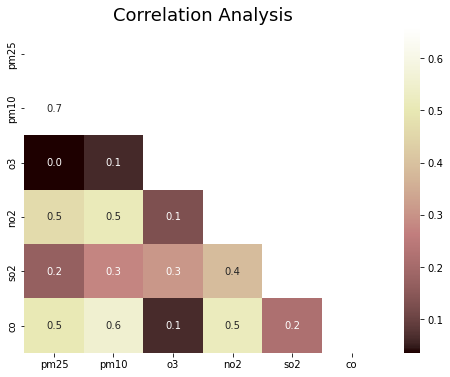

In [10]:
#correlation analysis

plt.figure(figsize=(8,6))

mask=np.triu(AQ_data[['date','pm25','pm10','o3','no2','so2','co']].corr(method='pearson'))
sns.heatmap(AQ_data[['date','pm25','pm10','o3','no2','so2','co']].corr(method='pearson'),
            annot=True,fmt='0.1f',
            mask=mask,
            robust=True,
            cmap='pink')
plt.title('Correlation Analysis', fontsize=18);

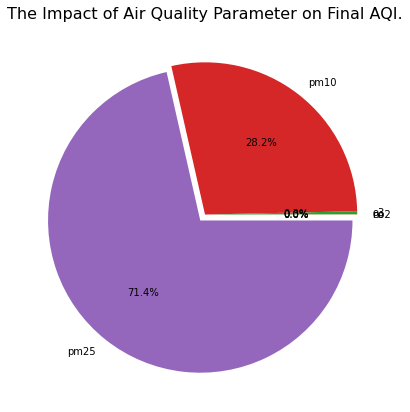

In [11]:
#This pie Chart describe how much time which parameter contributed in Final AQI.
# It can be clearly seen that PM2.5 is most important parameter in overall Air quality index

frequency_df = AQ_data.groupby('AQI_factor').count()
frequency_df['AQ_parameter']=frequency_df.index

plt.figure(figsize=(8,7))
plt.pie(frequency_df['AQI'], labels = frequency_df['AQ_parameter'],autopct='%3.1f%%',explode=(0,0 , 0,0,0.05))
plt.title("The Impact of Air Quality Parameter on Final AQI.", fontsize=16)
plt.show()

%matplotlib inline

### Below Boxplots clearly shows that when PM 2.5 is plotted for different year for the month of April, May and June,There is significant dip in overall level of PM2.5 in year 2020 (Complete lockdown in April to June 2020). This shows that Air quality improved due to lockdown.

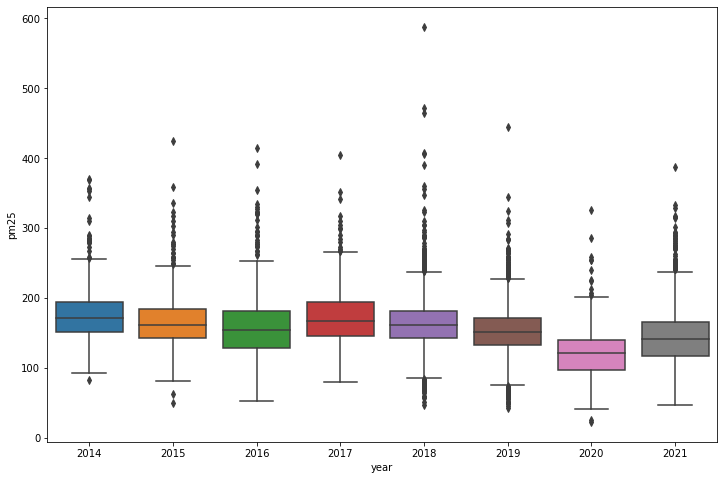

In [12]:
AQ_data['year']=AQ_data.date.dt.year
AQ_data['month']=AQ_data.date.dt.month
AQ_data_covid=AQ_data[(AQ_data['month']>=3) & ( AQ_data['month']<=6 )]
plt.figure(figsize=(12,8))

a = sns.boxplot(x= 'year', y = 'pm25', data= AQ_data_covid)
#a.set_title(f"Yearly Trend of from 2015 to 2020", fontsize=16)
display()

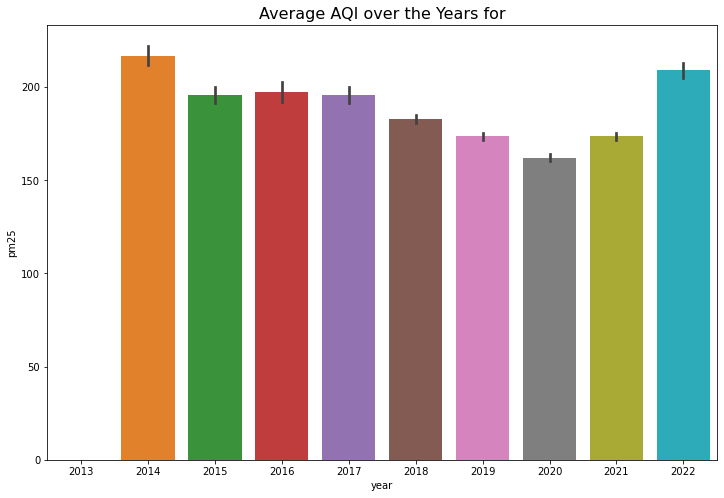

In [13]:
# Average AQI over the Years New Delhi.
plt.figure(figsize=(12,8))
sns.barplot(x='year', y='pm25', data=AQ_data)
plt.title(f"Average AQI over the Years for", fontsize=16)
display()

### Since PM 2.5 is most Crucial parameter for air quality, when PM2.5 is plotted for the 2020 to 2022, it is clearly visible that there is downfall in and after the Covid Lockdown period. 

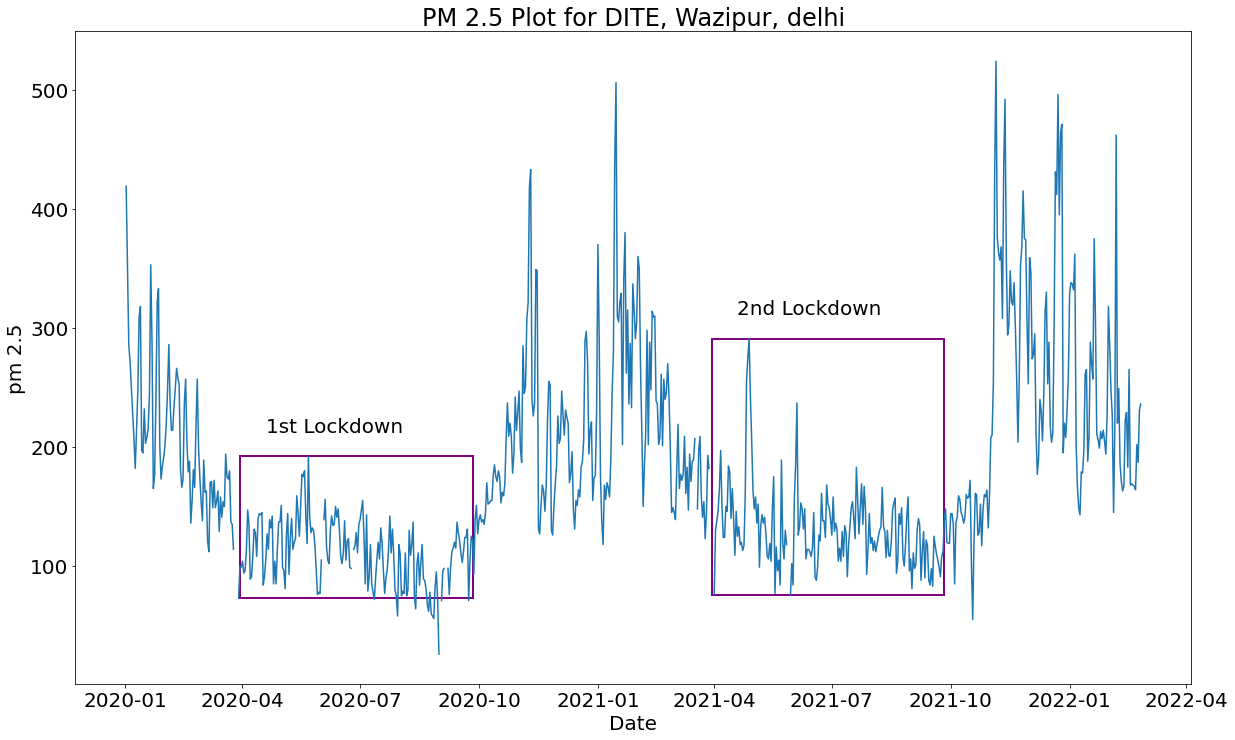

In [14]:
# Plot of daily PM2.5 level for DITE, Wazipur area

plt.rc('font', size=20)
fig, ax = plt.subplots(figsize=(20, 12))

AQ_data_DITE=AQ_data[AQ_data.filename=='Delhi Institute of Tool Engineering, Wazirpur, Delhi, Delhi, India']
AQ_data_DITE2=AQ_data_DITE[AQ_data_DITE.date>'2020-01-01']


#make a retangle around covid time:1st Lockdown
Covid_start_Date=mdates.date2num(np.datetime64('2020-03-30'))
Min_range=min(AQ_data_DITE2.pm25[(AQ_data_DITE2.date>'2020-03-20')& (AQ_data_DITE2.date<'2020-06-30')])
Max_range=max(AQ_data_DITE2.pm25[(AQ_data_DITE2.date>'2020-03-20')& (AQ_data_DITE2.date<'2020-06-30')])
Max_range=max(AQ_data_DITE2.pm25[(AQ_data_DITE2.date>'2020-03-20')& (AQ_data_DITE2.date<'2020-06-30')])
rect=mpatches.Rectangle((Covid_start_Date,Min_range),180,(Max_range-Min_range), fill = False,color = "purple",linewidth = 2)
plt.gca().add_patch(rect)
ax.text(Covid_start_Date+20, Max_range+20, '1st Lockdown')


#make a retangle around covid time:2nd Lockdown
Covid_start_Date2=mdates.date2num(np.datetime64('2021-03-30'))
Min_range2=min(AQ_data_DITE2.pm25[(AQ_data_DITE2.date>'2021-03-20')& (AQ_data_DITE2.date<'2021-06-30')])
Max_range2=max(AQ_data_DITE2.pm25[(AQ_data_DITE2.date>'2021-03-20')& (AQ_data_DITE2.date<'2021-06-30')])
Max_range2=max(AQ_data_DITE2.pm25[(AQ_data_DITE2.date>'2021-03-20')& (AQ_data_DITE2.date<'2021-06-30')])
rect=mpatches.Rectangle((Covid_start_Date2,Min_range2),180,(Max_range2-Min_range2), fill = False,color = "purple",linewidth = 2)
plt.gca().add_patch(rect)
ax.text(Covid_start_Date2+20, Max_range2+20, '2nd Lockdown')


#Sort dates for plotting                     
AQ_data_DITE2 = AQ_data_DITE2.set_index('date').sort_index().reset_index()
ax.plot(AQ_data_DITE2['date'],AQ_data_DITE2['pm25'])

# Same as above
ax.set_xlabel('Date')
ax.set_ylabel('pm 2.5')
ax.set_title('PM 2.5 Plot for DITE, Wazipur, delhi')
#ax.grid(True)
#ax.legend(loc='upper left');
plt.show()

### There maybe two possibility for above: dip in PM2.5 level in the lockdown time maybe due to lockdown effect or it is naturally low in this period. To validate it, When i compare the daily Pm2.5 level of for the month of April, may, june and July which are the lockdown month, of 2020 with 2019 and 2018, then also it is found that there is downfall in the year 2020 in overall AQI

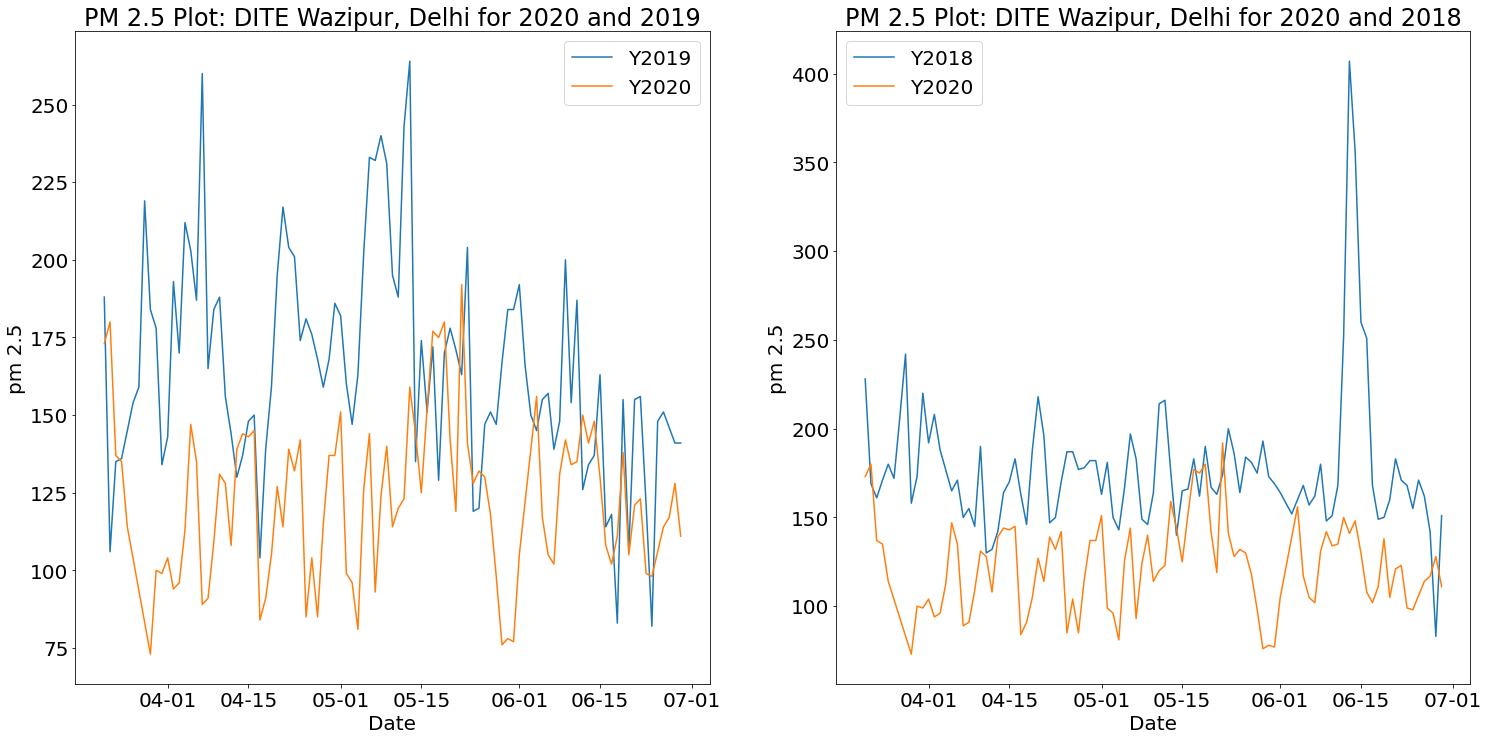

In [15]:
#Comparasion between PM2.5 for year 2020, 2019 and 2018

AQ_data_DITE2019=AQ_data_DITE[(AQ_data_DITE.date>'2019-03-20') & (AQ_data_DITE.date<'2019-06-30')]
AQ_data_DITE2020=AQ_data_DITE[(AQ_data_DITE.date>'2020-03-20') & (AQ_data_DITE.date<'2020-06-30')]
AQ_data_DITE2018=AQ_data_DITE[(AQ_data_DITE.date>'2018-03-20') & (AQ_data_DITE.date<'2018-06-30')]


fig, (ax1,ax2) = plt.subplots(figsize=(25, 12),nrows=1, ncols=2)

AQ_data_DITE2019 = AQ_data_DITE2019.set_index('date').sort_index().reset_index()
AQ_data_DITE2019['month']=(AQ_data_DITE2019['date']).dt.month
AQ_data_DITE2019['day']=(AQ_data_DITE2019['date']).dt.day

AQ_data_DITE2020 = AQ_data_DITE2020.set_index('date').sort_index().reset_index()
AQ_data_DITE2020['month']=(AQ_data_DITE2020['date']).dt.month
AQ_data_DITE2020['day']=(AQ_data_DITE2020['date']).dt.day

AQ_data_DITE2018 = AQ_data_DITE2018.set_index('date').sort_index().reset_index()
AQ_data_DITE2018['month']=(AQ_data_DITE2018['date']).dt.month
AQ_data_DITE2018['day']=(AQ_data_DITE2018['date']).dt.day


result= pd.merge(AQ_data_DITE2019,AQ_data_DITE2020,on=['month','day'],how='outer')
result['pm25_x']=result['pm25_x'].interpolate(method ='linear', limit_direction ='forward')
result['pm25_y']=result['pm25_y'].interpolate(method ='linear', limit_direction ='forward')

result= pd.merge(result,AQ_data_DITE2018,on=['month','day'],how='outer')
result['pm25_x']=result['pm25_x'].interpolate(method ='linear', limit_direction ='forward')
result['pm25_y']=result['pm25_y'].interpolate(method ='linear', limit_direction ='forward')
result['pm25']=result['pm25'].interpolate(method ='linear', limit_direction ='forward')

#Plot 1 Comparasion between PM2.5 for year 2020 and 2019
ax1.plot(result['date_x'],result['pm25_x'],label='Y2019')
ax1.plot(result['date_x'],result['pm25_y'],label='Y2020')
#ax1.plot(result['date_x'],result['pm25'],label='Y2018')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax1.set_xlabel('Date')
ax1.set_ylabel('pm 2.5')
ax1.set_title('PM 2.5 Plot: DITE Wazipur, Delhi for 2020 and 2019')
ax1.legend()


#plot 2 Comparasion between PM2.5 for year 2020 and 2019
ax2.plot(result['date_x'],result['pm25'],label='Y2018')
ax2.plot(result['date_x'],result['pm25_y'],label='Y2020')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax2.set_xlabel('Date')
ax2.set_ylabel('pm 2.5')
ax2.set_title('PM 2.5 Plot: DITE Wazipur, Delhi for 2020 and 2018')
ax2.legend()


plt.show()

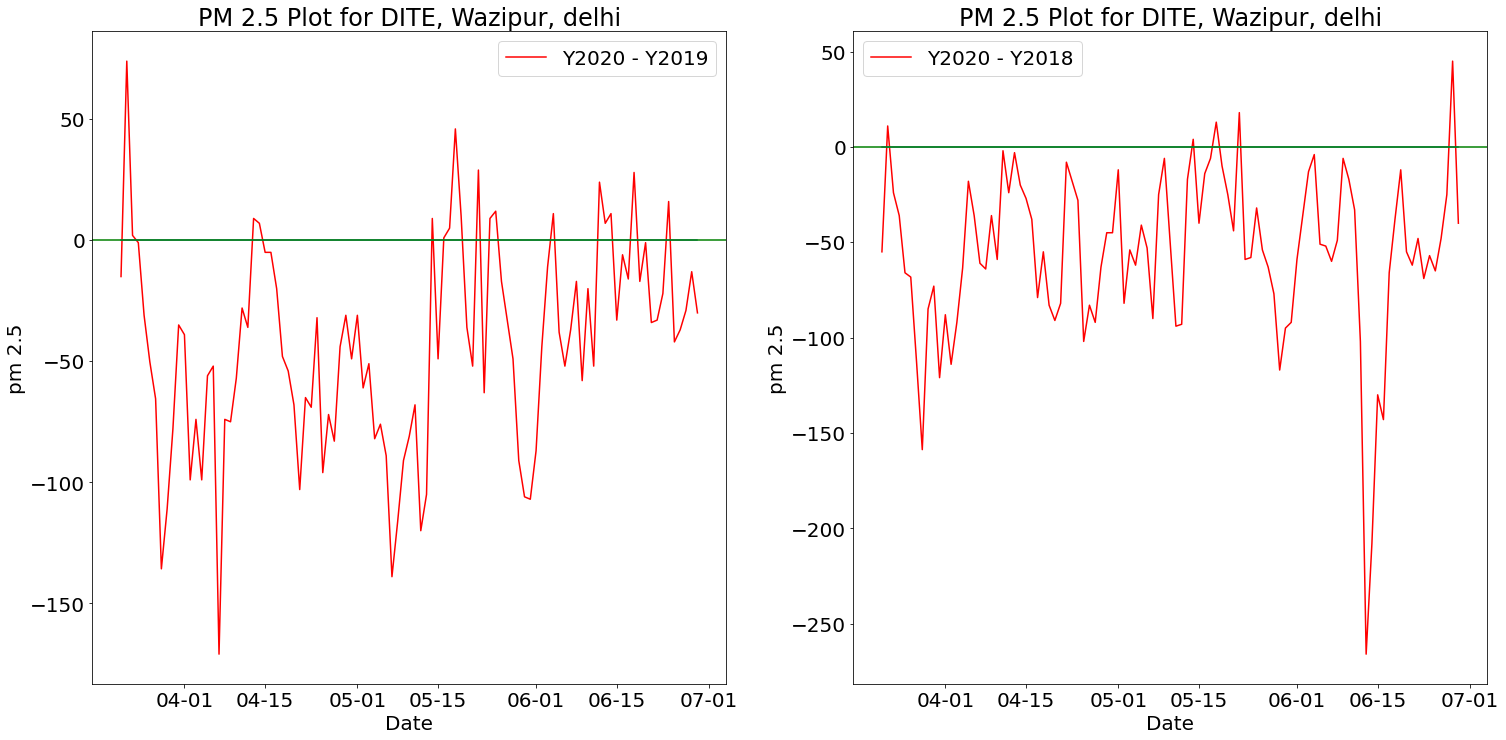

In [16]:
# Difference in AQI from 2018 and 2019 to 2020 for Covid Month

fig, (ax1,ax2) = plt.subplots(figsize=(25, 12),nrows=1, ncols=2)

#Plot 1: Difference between PM2.5 for year 2020 and 2019
ax1.plot(result['date_x'],(result['pm25_y']-result['pm25_x']),label='Y2020 - Y2019',color = 'r')
ax1.plot(result['date_x'],(result['pm25_y']-result['pm25_y']))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax1.set_xlabel('Date')
ax1.set_ylabel('pm 2.5')
ax1.set_title('PM 2.5 Plot for DITE, Wazipur, delhi')

ax1.axhline(y = 0,color = 'g', linestyle = '-')
ax1.legend()


#plot 2: Difference between PM2.5 for year 2020 and 2019
ax2.plot(result['date_x'],(result['pm25_y']-result['pm25']),label='Y2020 - Y2018',color = 'r')
ax2.plot(result['date_x'],(result['pm25_y']-result['pm25_y']))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))


ax2.set_xlabel('Date')
ax2.set_ylabel('pm 2.5')
ax2.set_title('PM 2.5 Plot for DITE, Wazipur, delhi')

ax2.axhline(y = 0,color = 'g', linestyle = '-')
ax2.legend()

plt.show()


### Above comparasion is visiualise on several points and same lockdown effect was visible on every point. to see this change, I will plot those parameter over the map of delhi over time and it will be much easier to visualise

In [17]:
#Open Delhi Area Shapefile
delhi_map = gpd.read_file('Delhi_Shapefile/Delhi_Wards.shp')
print(delhi_map.crs)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


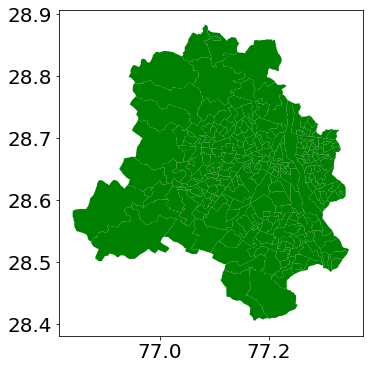

In [18]:
# Area of Working: Delhi
ax = delhi_map.plot(color='green',figsize=(10, 6))

In [19]:
AQ_data.head()

,date,pm25,pm10,o3,no2,so2,co,filename,lat,lon,uid,city,AQI,AQI_factor,year,month
0,2022-02-01,284.0,149.0,37.0,19.0,3.0,12.0,"Mundka, Delhi, Delhi, India",28.68241,77.030469,10708,Delhi,284.0,pm25,2022,2
1,2022-02-02,228.0,122.0,16.0,16.0,4.0,12.0,"Mundka, Delhi, Delhi, India",28.68241,77.030469,10708,Delhi,228.0,pm25,2022,2
2,2022-02-03,216.0,61.0,22.0,12.0,4.0,10.0,"Mundka, Delhi, Delhi, India",28.68241,77.030469,10708,Delhi,216.0,pm25,2022,2
3,2022-02-04,126.0,98.0,19.0,16.0,5.0,14.0,"Mundka, Delhi, Delhi, India",28.68241,77.030469,10708,Delhi,126.0,pm25,2022,2
4,2022-02-05,177.0,322.0,31.0,26.0,2.0,21.0,"Mundka, Delhi, Delhi, India",28.68241,77.030469,10708,Delhi,322.0,pm10,2022,2


In [20]:
Station_list = pd.pivot_table(data=AQ_data[['filename','lat','lon']], 
                        index=['filename'], 
                        values=['lat','lon'])
Station_list

,lat,lon
filename,,
"Alipur, Delhi, Delhi, India",28.815691,77.152491
"Anand Vihar, Delhi, Delhi, India",28.645892,77.314853
"Bramprakash Ayurvedic Hospital, Najafgarh, Delhi, Delhi, India",28.572714,76.933433
"Delhi Institute of Tool Engineering, Wazirpur, Delhi, Delhi, India",28.700505,77.165603
"ITI Jahangirpuri, Delhi, Delhi, India",28.733016,77.171970
"ITI Shahdra, Jhilmil Industrial Area, Delhi, Delhi, India",28.672114,77.313832
"Jawaharlal Nehru Stadium, Delhi, Delhi, India",28.582846,77.234366
"Major Dhyan Chand National Stadium, Delhi, Delhi, India",28.612498,77.237388
"Mandir Marg, Delhi, Delhi, India",28.630362,77.197293


### Locations for which air quality data were used in this study is plotted over the delhi map. It can be seen in  the map that points considered for the study is well dispersed over the study region.

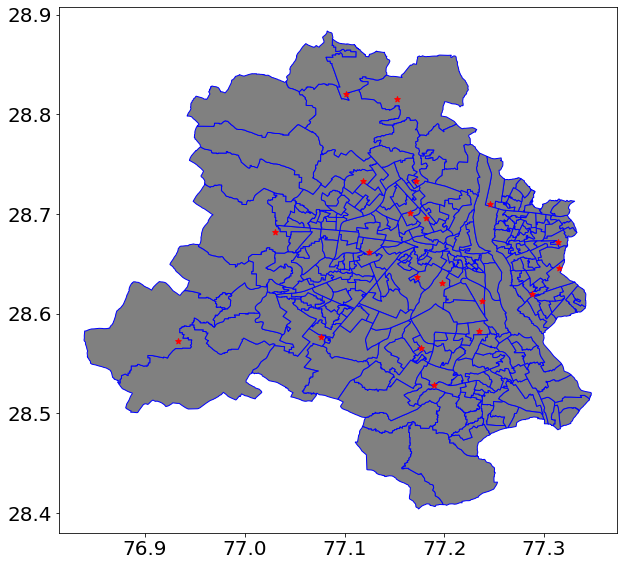

In [21]:
#Plot points over the map
fig,ax = plt.subplots(figsize = (10,10))
delhi_map.plot(ax = ax,color='gray',edgecolor='blue')
geometry=gpd.points_from_xy(Station_list.lon,Station_list.lat)
geo_df = gpd.GeoDataFrame(geometry = geometry)
g = geo_df.plot(ax = ax, markersize = 35, color = 'red',marker = '*',label = 'Delhi')
plt.show()

In [22]:
AQ_data['date1']=AQ_data['date']

In [23]:
obervation_dates = pd.pivot_table(data=AQ_data[['date','date1']], 
                        index=['date'], 
                        values=['date1'])
print(obervation_dates)

                date1
date                 
2013-12-31 2013-12-31
2014-01-01 2014-01-01
2014-01-02 2014-01-02
2014-01-03 2014-01-03
2014-01-04 2014-01-04
...               ...
2022-02-24 2022-02-24
2022-02-25 2022-02-25
2022-02-26 2022-02-26
2022-02-27 2022-02-27
2022-02-28 2022-02-28

[2960 rows x 1 columns]


### Geopandas is very popular library which is used to save geospatial datasets into dataframe. Location parameters are attached along with normal dataset in the geopandas dataframe which makes it more convinient in geospatial analysis. THis dataframe will now converted into geopandas dataframe and analysis will be done over it.

In [24]:
#convert dataframe into geodataframe
AQ_data_gdf = gpd.GeoDataFrame(AQ_data, geometry=gpd.points_from_xy(AQ_data.lon, AQ_data.lat))

In [25]:
display(AQ_data_gdf.head())

,date,pm25,pm10,o3,no2,so2,co,filename,lat,lon,uid,city,AQI,AQI_factor,year,month,date1,geometry
0,2022-02-01,284.0,149.0,37.0,19.0,3.0,12.0,"Mundka, Delhi, Delhi, India",28.68241,77.030469,10708,Delhi,284.0,pm25,2022,2,2022-02-01,POINT (77.03047 28.68241)
1,2022-02-02,228.0,122.0,16.0,16.0,4.0,12.0,"Mundka, Delhi, Delhi, India",28.68241,77.030469,10708,Delhi,228.0,pm25,2022,2,2022-02-02,POINT (77.03047 28.68241)
2,2022-02-03,216.0,61.0,22.0,12.0,4.0,10.0,"Mundka, Delhi, Delhi, India",28.68241,77.030469,10708,Delhi,216.0,pm25,2022,2,2022-02-03,POINT (77.03047 28.68241)
3,2022-02-04,126.0,98.0,19.0,16.0,5.0,14.0,"Mundka, Delhi, Delhi, India",28.68241,77.030469,10708,Delhi,126.0,pm25,2022,2,2022-02-04,POINT (77.03047 28.68241)
4,2022-02-05,177.0,322.0,31.0,26.0,2.0,21.0,"Mundka, Delhi, Delhi, India",28.68241,77.030469,10708,Delhi,322.0,pm10,2022,2,2022-02-05,POINT (77.03047 28.68241)


In [26]:
# map of delhi is associated a reference system to it. here same crs is attached to our geodataframe of AQI dataset
AQ_data_gdf=AQ_data_gdf.set_crs(delhi_map.crs)

In [27]:
# Start date and End date are index of dates from we have to start and end the plotting of the map.

obervation_dates.reset_index(inplace=True)
Start_date=obervation_dates[obervation_dates['date1']=='2020-01-20'].index.tolist()
End_date=obervation_dates[obervation_dates['date1']=='2020-07-30'].index.tolist()

## Voronoi polygon is very popular method to interpolate over vector dataset. Here daily PM2.5 level is plotted over map and one GIF is created in next step to make it  more visually understandable.


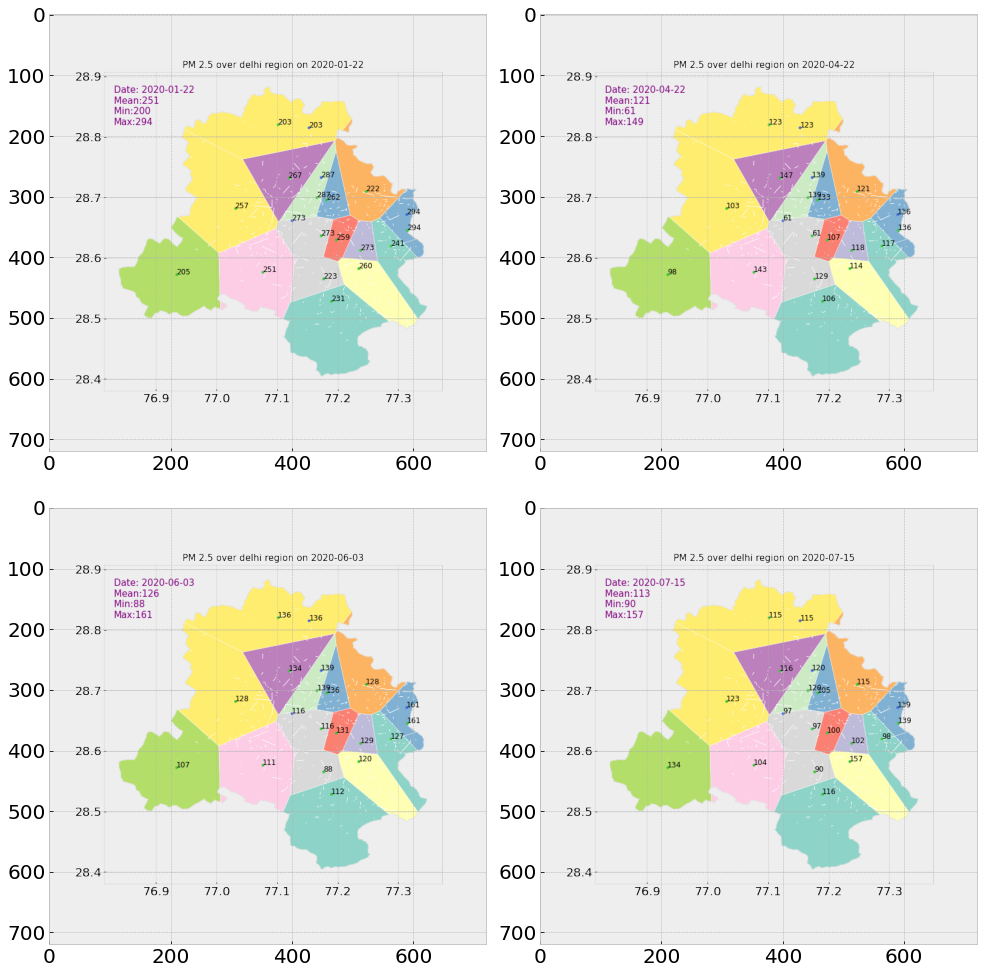

In [28]:
for i in range(Start_date[0],End_date[0]):
    AQ_data_daily=AQ_data_gdf[AQ_data_gdf['date']==obervation_dates['date1'][i]]
    
    mean_value=AQ_data_daily['pm25'].mean()
    AQ_data_daily['pm25'].fillna(value=mean_value,inplace=True)
    
    # Get X and Y coordinates of AQ stations
    x_station = AQ_data_daily["geometry"].x
    y_station = AQ_data_daily["geometry"].y
    coords_station = [list(xy) for xy in zip(x_station, y_station)]

    # Get extent of Delhi area
    min_x_delhi, min_y_delhi, max_x_delhi, max_y_delhi = delhi_map.total_bounds

    # Get list of PM2.5 values for datapoints
    value_station = list(AQ_data_daily["pm25"])

    # Create a copy of delhi dataset
    AQ_dissolved = delhi_map.copy()

    # Add a field with constant value of 1
    AQ_dissolved["constant"] = 1

    # Dissolve all parts to create one polygon
    AQ_dissolved = AQ_dissolved.dissolve(by = "constant").reset_index(drop = True)
    
    # Split data into testing and training sets
    coords_station_train, coords_station_test, value_station_train, value_station_test = train_test_split(coords_station, value_station, test_size = 0.20, random_state = 10)

    # Create separate GeoDataFrames for testing and training sets
    AQ_train_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_station_train])
    AQ_train_gdf["Actual_Value"] = value_station_train
    AQ_test_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_station_test])
    AQ_test_gdf["Actual_Value"] = value_station_test

    # Get minimum and maximum coordinate values of AQ training points
    min_x_AQ, min_y_AQ, max_x_AQ, max_y_AQ = AQ_train_gdf.total_bounds
    
    
    # Extend extent of counties feature by using buffer
    delhi_buffer = delhi_map.buffer(1)
    min_x_cty_tp, min_y_cty_tp, max_x_cty_tp, max_y_cty_tp = delhi_buffer.total_bounds

    # Use extent to create dummy points and add them to list of coordinates
    coords_final = coords_station_train + [[min_x_cty_tp, min_y_cty_tp], [max_x_cty_tp, min_y_cty_tp],
                                     [max_x_cty_tp, max_y_cty_tp], [min_x_cty_tp, max_y_cty_tp]]

    # Compute Voronoi diagram
    tp = Voronoi(coords_final)
    tp_poly_list = []
    for region in tp.regions:
        # Ignore region if -1 is in the list (based on documentation)
        if -1 in region:
            # Return to top of loop
            continue
        # Otherwise, pass
        else:
            pass
        # Check that region list has values in it
        if len(region) != 0:
            # Create a polygon by using the region list to call the correct elements in the 'vertices' attribute
            tp_poly_region = Polygon(list(tp.vertices[region]))

            # Append polygon to list
            tp_poly_list.append(tp_poly_region)
        # If no values, return to top of loop
        else:
            continue

    # Create GeoDataFrame from list of polygon regions
    AQ_polys = gpd.GeoDataFrame(tp_poly_list, columns = ['geometry'])

    # Clip polygon regions to the delhi boundary and drop un-needed column
    AQ_polys_clipped = gpd.clip(AQ_polys, AQ_dissolved)
    tp_polys_clipped_values = gpd.sjoin(AQ_train_gdf, AQ_polys_clipped, how = "right", op = 'within')
    tp_polys_clipped_values = tp_polys_clipped_values.drop("index_left", axis = 1)
    tp_polys_clipped_values = tp_polys_clipped_values.rename(columns = {"Actual_Value": "VALUE_Thiessen"})

    # If test point is within a polygon, assign that polygon's value to the test point
    rain_test_pred_tp = gpd.sjoin(AQ_test_gdf, tp_polys_clipped_values, how = "left", op = 'within')
    rain_test_pred_tp = rain_test_pred_tp.drop("index_right", axis = 1)
    rain_test_pred_tp = rain_test_pred_tp.rename(columns = {"Actual_Value": "VALUE_Actual", "VALUE_Thiessen": "VALUE_Predict"})

    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))

    # Stylize plots
    plt.style.use('bmh')

    # Plot data
    AQ_dissolved.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
    AQ_polys_clipped.plot(ax = ax, cmap = 'Set3', edgecolor = 'white', linewidth = 0.5)
    AQ_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 15)
    rain_test_pred_tp.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 15)

    for index, row in AQ_train_gdf.iterrows():
        plt.annotate(int(row.Actual_Value), (row.geometry.x, row.geometry.y),fontsize=12)

    for index, row in rain_test_pred_tp.iterrows():
        plt.annotate(int(row.VALUE_Predict), (row.geometry.x, row.geometry.y),fontsize=12)

    # Set title
    ax.text(76.83,28.82, 'Date: {} \nMean:{} \nMin:{} \nMax:{}'.format(obervation_dates['date1'][i].date(),int(AQ_data_daily.pm25.mean()),int(AQ_data_daily.pm25.min()),int(AQ_data_daily.pm25.max())), size=15, color='purple')
    ax.set_title('PM 2.5 over delhi region on {}'.format(obervation_dates['date1'][i].date()), fontdict = {'fontsize': '15', 'fontweight' : '3'})
    
    if i%7==0:
        
        plt.savefig("GIF_Plot/plot_{}.png".format(obervation_dates['date1'][i].date()))
    plt.close()

plt.rcParams["figure.figsize"] = [14.00, 14.0]
plt.rcParams["figure.autolayout"] = True

plt.subplot(2, 2, 1)
plt.imshow(mpimg.imread('GIF_Plot/plot_2020-01-22.png'))
plt.subplot(2, 2, 2)
plt.imshow(mpimg.imread('GIF_Plot/plot_2020-04-22.png'))
plt.subplot(2, 2, 3)
plt.imshow(mpimg.imread('GIF_Plot/plot_2020-06-03.png'))
plt.subplot(2, 2, 4)
plt.imshow(mpimg.imread('GIF_Plot/plot_2020-07-15.png'))
plt.show()

### All maps are then joined and converted into GIF where change can be seen happening over time in the lockdown time. betterment of mean and max values of pm2.5 can be observed in the lockdown time 

In [29]:
# filepaths
fp_in = "GIF_Plot/plot_*.png"
fp_out = "GIF_output/Delhi_AQ_GIF.gif"

imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,save_all=True, duration=10, loop=0)
IPython.display.HTML('<img src="{}">'.format('GIF_output/Delhi_AQ_GIF.gif'))

## In the above interpolation using voronoi polygon, interpolation is not that good and sudden changes are there. This is because lack of datapoint across the map. Voronoi polygons will be much smaller and precise when number of observation points are higher. To overcome this AQI is interpolated over the area for the delhi region using inverse distance weighted average method. A raster is created and than it is masked over the study area and value is interpolated over every pixel. Then GIF is created from those charts of different timeframe.

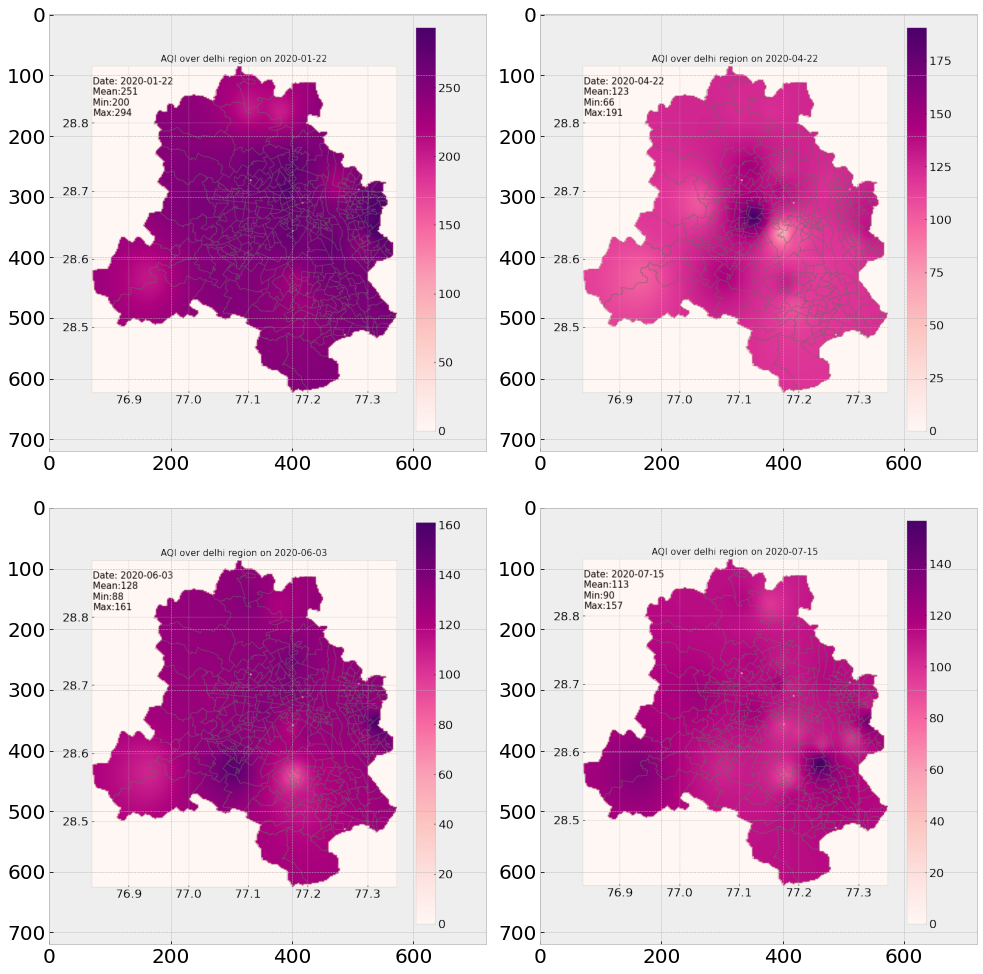

In [30]:
for i in range(Start_date[0],End_date[0]):
    AQ_data_daily=AQ_data_gdf[AQ_data_gdf['date']==obervation_dates['date1'][i]]
    
    mean_value=AQ_data_daily['AQI'].mean()
    AQ_data_daily['AQI'].fillna(value=mean_value, inplace=True)
    
    AQ_data_daily=AQ_data_daily.set_crs(delhi_map.crs)
    
    x=AQ_data_daily.drop(['date','date1'],axis=1)
    
    x.to_file('AQI_meter_coordinate/coordinate.shp')
    
    nn = gdal.Grid("AQI_meter_coordinate/Raster_file.tif", "AQI_meter_coordinate/coordinate.shp", zfield='AQI',
               algorithm = "invdist", outputBounds = [76.8,28.4,77.4,28.9],
               width = .01, height = .01)

    nn.FlushCache()
    nn = None
    
    raster_pk = rasterio.open("AQI_meter_coordinate/Raster_file.tif")
    out_image_pk, out_transform_pk = msk.mask(raster_pk, delhi_map.geometry.values, crop = True)
    
    # Stylize plots
    plt.style.use('bmh')

    # Plot data
    fig, ax = plt.subplots(1, figsize = (10, 10))
    Img=rasplot.show(out_image_pk, ax = ax, transform = out_transform_pk, cmap = "RdPu")
    img2 = Img.get_images()[0]
    fig.colorbar(img2, ax=ax)
    ax.text(76.84,28.81,'Date: {} \nMean:{} \nMin:{} \nMax:{}'.format(obervation_dates['date1'][i].date(),int(AQ_data_daily.AQI.mean()),int(AQ_data_daily.AQI.min()),int(AQ_data_daily.AQI.max())), size=15, color='black')
    ax.set_title('AQI over delhi region on {}'.format(obervation_dates['date1'][i].date()), fontdict = {'fontsize': '15', 'fontweight' : '3'})
    delhi_map.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
    plt.gca().invert_yaxis()
    
    
    if i%7==0:
        plt.savefig("GIF_Plots_IDW/plot_{}.png".format(obervation_dates['date1'][i].date()))
    plt.close()
    #plt.colorbar()
    #ax.plot(x_rain, y_rain, 'k.', markersize = 2, alpha = 0.5)


plt.rcParams["figure.figsize"] = [14.00, 14.0]
plt.rcParams["figure.autolayout"] = True

plt.subplot(2, 2, 1)
plt.imshow(mpimg.imread('GIF_Plots_IDW/plot_2020-01-22.png'))
plt.subplot(2, 2, 2)
plt.imshow(mpimg.imread('GIF_Plots_IDW/plot_2020-04-22.png'))
plt.subplot(2, 2, 3)
plt.imshow(mpimg.imread('GIF_Plots_IDW/plot_2020-06-03.png'))
plt.subplot(2, 2, 4)
plt.imshow(mpimg.imread('GIF_Plots_IDW/plot_2020-07-15.png'))
plt.show()

In [31]:
#GIF for the lockdown time
# filepaths
fp_in = "GIF_Plots_IDW/plot_*.png"
fp_out = "GIF_output/Delhi_AQ_GIF_IDW.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,save_all=True, duration=10, loop=0)
IPython.display.HTML('<img src="{}">'.format('GIF_output/Delhi_AQ_GIF_IDW.gif'))

In [32]:
#UTM Projection for the delhi region
proj="+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs"

## Flow of AQI at various locations over time
### Now here i tried to visualise, location wise AQI variation over time and what are the locations which has higher AQI compared to other locations. Here also it will be visible that in the lockdown timeframes, AQI is much lower at all the locations in delhi

In [33]:
#A new column of place is extracted from full name
AQ_data_gdf['Place'] = AQ_data_gdf['filename'].str.rsplit(',').str[0]
AQ_data_gdf['Place']

#data is converted at the cuts of Date and place
AQ_data_by_filename = pd.pivot_table(data=AQ_data_gdf, index=['date'],values=['AQI'],columns='Place')
AQ_data_by_filename=AQ_data_by_filename['AQI']
AQ_data_by_filename.reset_index(inplace=True)

In [34]:
def prepare_data(df, steps=5):
    df = df.reset_index()
    df.index = df.index * steps
    last_idx = df.index[-1] + 1
    df_expanded = df.reindex(range(last_idx))
    df_expanded['date'] = df_expanded['date'].fillna(method='ffill')
    df_expanded = df_expanded.set_index('date')
    df_rank_expanded = df_expanded.rank(axis=1, method='first')
    df_expanded = df_expanded.interpolate()
    df_rank_expanded = df_rank_expanded.interpolate()
    return df_expanded, df_rank_expanded

AQ_data_by_filename=AQ_data_by_filename[(AQ_data_by_filename['date']>'2019-12-01')&(AQ_data_by_filename['date']<'2020-12-01')]

#take every 7th value to make it more visuslly attractive. In the daily plot, changes are not visually understandable clearly
AQ_data_by_filename=AQ_data_by_filename.iloc[::7, :]

df_expanded, df_rank_expanded = prepare_data(AQ_data_by_filename)
df_expanded

Place,index,Alipur,Anand Vihar,Bramprakash Ayurvedic Hospital,Delhi Institute of Tool Engineering,ITI Jahangirpuri,ITI Shahdra,Jawaharlal Nehru Stadium,Major Dhyan Chand National Stadium,Mandir Marg,...,Mundka,Narela,National Institute of Malaria Research,Punjabi Bagh,Pusa,R.K. Puram,Satyawati College,Shaheed Sukhdev College of Business Studies,Sonia Vihar Water Treatment Plant DJB,Sri Auribindo Marg
date,,,,,,,,,,,,,,,,,,,,,
2019-12-02,2141.0,138.0,229.0,177.0,249.0,NaN,200.0,207.0,177.0,194.0,...,244.0,211.0,251.0,202.0,200.0,181.0,222.0,271.0,198.0,175.0
2019-12-02,2142.4,167.4,254.4,184.0,279.4,NaN,219.0,221.0,185.8,202.8,...,260.6,218.0,286.4,210.2,214.4,192.2,239.0,289.4,206.6,184.6
2019-12-02,2143.8,196.8,279.8,191.0,309.8,NaN,238.0,235.0,194.6,211.6,...,277.2,225.0,321.8,218.4,228.8,203.4,256.0,307.8,215.2,194.2
2019-12-02,2145.2,226.2,305.2,198.0,340.2,NaN,257.0,249.0,203.4,220.4,...,293.8,232.0,357.2,226.6,243.2,214.6,273.0,326.2,223.8,203.8
2019-12-02,2146.6,255.6,330.6,205.0,370.6,NaN,276.0,263.0,212.2,229.2,...,310.4,239.0,392.6,234.8,257.6,225.8,290.0,344.6,232.4,213.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-17,2492.4,181.8,208.0,173.0,188.2,226.2,215.4,180.0,186.6,193.0,...,223.8,213.6,185.0,199.6,189.8,189.8,215.0,226.8,229.2,171.8
2020-11-17,2493.8,212.6,250.0,194.0,249.4,275.4,260.8,205.0,218.2,225.0,...,279.6,264.2,210.0,238.2,216.6,213.6,265.0,290.6,298.4,185.6
2020-11-17,2495.2,243.4,292.0,215.0,310.6,324.6,306.2,230.0,249.8,257.0,...,335.4,314.8,235.0,276.8,243.4,237.4,315.0,354.4,367.6,199.4


In [35]:
df_expanded = df_expanded.interpolate()
df_expanded=df_expanded.drop(columns=['index'])
df_rank_expanded
df_rank_expanded=df_rank_expanded.drop(columns=['index'])
df_expanded

Place,Alipur,Anand Vihar,Bramprakash Ayurvedic Hospital,Delhi Institute of Tool Engineering,ITI Jahangirpuri,ITI Shahdra,Jawaharlal Nehru Stadium,Major Dhyan Chand National Stadium,Mandir Marg,Mother Dairy Plant,Mundka,Narela,National Institute of Malaria Research,Punjabi Bagh,Pusa,R.K. Puram,Satyawati College,Shaheed Sukhdev College of Business Studies,Sonia Vihar Water Treatment Plant DJB,Sri Auribindo Marg
date,,,,,,,,,,,,,,,,,,,,
2019-12-02,138.0,229.0,177.0,249.0,NaN,200.0,207.0,177.0,194.0,195.0,244.0,211.0,251.0,202.0,200.0,181.0,222.0,271.0,198.0,175.0
2019-12-02,167.4,254.4,184.0,279.4,NaN,219.0,221.0,185.8,202.8,206.2,260.6,218.0,286.4,210.2,214.4,192.2,239.0,289.4,206.6,184.6
2019-12-02,196.8,279.8,191.0,309.8,NaN,238.0,235.0,194.6,211.6,217.4,277.2,225.0,321.8,218.4,228.8,203.4,256.0,307.8,215.2,194.2
2019-12-02,226.2,305.2,198.0,340.2,NaN,257.0,249.0,203.4,220.4,228.6,293.8,232.0,357.2,226.6,243.2,214.6,273.0,326.2,223.8,203.8
2019-12-02,255.6,330.6,205.0,370.6,NaN,276.0,263.0,212.2,229.2,239.8,310.4,239.0,392.6,234.8,257.6,225.8,290.0,344.6,232.4,213.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-17,181.8,208.0,173.0,188.2,226.2,215.4,180.0,186.6,193.0,197.2,223.8,213.6,185.0,199.6,189.8,189.8,215.0,226.8,229.2,171.8
2020-11-17,212.6,250.0,194.0,249.4,275.4,260.8,205.0,218.2,225.0,236.4,279.6,264.2,210.0,238.2,216.6,213.6,265.0,290.6,298.4,185.6
2020-11-17,243.4,292.0,215.0,310.6,324.6,306.2,230.0,249.8,257.0,275.6,335.4,314.8,235.0,276.8,243.4,237.4,315.0,354.4,367.6,199.4


In [36]:
labels = df_expanded.columns
labels

Index(['Alipur', 'Anand Vihar', 'Bramprakash Ayurvedic Hospital',
       'Delhi Institute of Tool Engineering', 'ITI Jahangirpuri',
       'ITI Shahdra', 'Jawaharlal Nehru Stadium',
       'Major Dhyan Chand National Stadium', 'Mandir Marg',
       'Mother Dairy Plant', 'Mundka', 'Narela',
       'National Institute of Malaria Research', 'Punjabi Bagh', 'Pusa',
       'R.K. Puram', 'Satyawati College',
       'Shaheed Sukhdev College of Business Studies',
       'Sonia Vihar Water Treatment Plant DJB', 'Sri Auribindo Marg'],
      dtype='object', name='Place')

In [37]:
def nice_axes(ax):
    ax.set_facecolor('.8')
    ax.tick_params(labelsize=5, length=0)
    ax.grid(True, axis='x', color='white')
    ax.set_axisbelow(True)
    [spine.set_visible(False) for spine in ax.spines.values()]
    
colors = plt.cm.Dark2(range(6))

%matplotlib qt
def init():
    ax.clear()
    nice_axes(ax)
    ax.set_ylim(.2, 6.8)
def update(i):
    for bar in ax.containers:
        bar.remove()
    y = df_rank_expanded.iloc[i]
    width = df_expanded.iloc[i]
    ax.barh(y=y, width=width, color=colors, tick_label=labels)
    date_str = df_expanded.index[i].strftime('%B %-d, %Y')
    ax.set_title(f'Daily AQI of various location in delhi- {date_str}', fontsize='smaller')
    
fig = plt.Figure(figsize=(7, 3.5), dpi=144)
ax = fig.add_subplot()

anim = FuncAnimation(fig=fig, func=update, init_func=init, frames=len(df_expanded), 
                     interval=100, repeat=False)

In [38]:
#save the animation
anim.save('GIF_output/covid19.mp4')

#convert into GIF
clip = (VideoFileClip("GIF_output/covid19.mp4"))
clip.write_gif("GIF_output/covid19.gif")

IPython.display.HTML('<img src="{}">'.format('GIF_output/covid19.gif'))

MoviePy - Building file GIF_output/covid19.gif with imageio.
